In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
from vectorspline3d import VectorSpline3D
from vectorspline3d.utils import sample_from_grid

In [2]:
grid = xr.open_dataset("../../data/xvel_2017.grd")
grid["north_velocity"] = xr.open_dataarray('../../data/yvel_2017.grd')
grid["up_velocity"] = xr.open_dataarray('../../data/zvel_2017.grd')
grid = grid.rename(dict(z="east_velocity", x="easting", y="northing"))
grid = grid.sel(easting=slice(250, 800, 5), northing=slice(30, 600, 5))
region = vd.get_region((grid.easting, grid.northing))
spacing = 2.5
grid_coords = np.meshgrid(grid.easting, grid.northing)
grid_components = (grid.east_velocity.values, grid.north_velocity.values, grid.up_velocity.values)
grid

<xarray.Dataset>
Dimensions:         (easting: 220, northing: 228)
Coordinates:
  * easting         (easting) float64 250.2 252.8 255.2 ... 792.8 795.2 797.8
  * northing        (northing) float64 30.25 32.75 35.25 ... 592.8 595.2 597.8
Data variables:
    east_velocity   (northing, easting) float32 0.071261406 ... 0.67221326
    north_velocity  (northing, easting) float32 17.78959 17.794144 ... -18.34808
    up_velocity     (northing, easting) float32 0.14165017 ... 0.07660963
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdcut
    history:      grdcut xvel_2017.grd -Gxvel_2017c.grd -R0/1000/0/1700
    description:  
    GMT_version:  5.4.2 (r18461) [64-bit]
    node_offset:  1

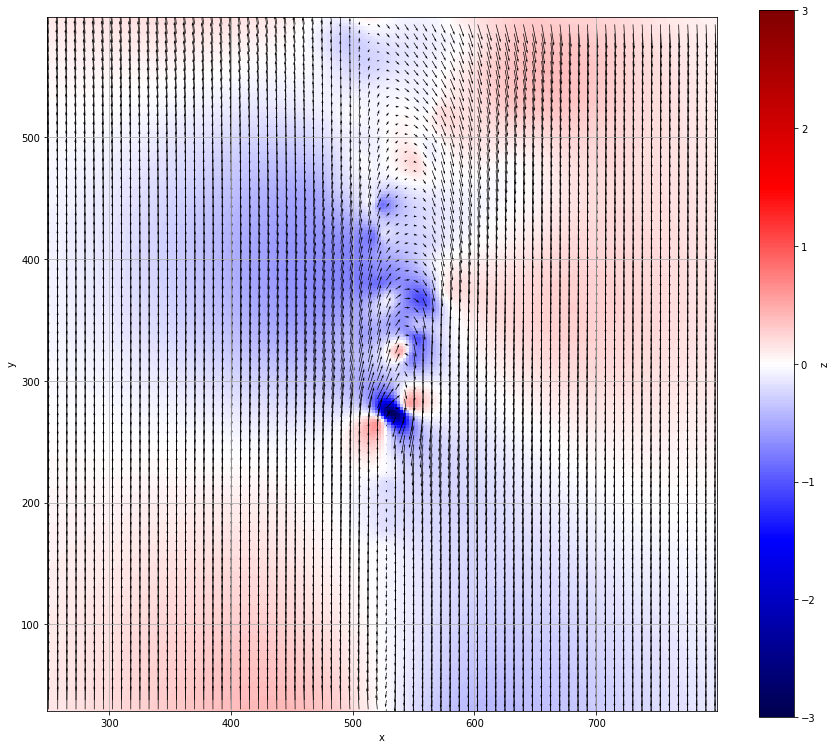

In [3]:
plt.figure(figsize=(15, 13))
ax = plt.subplot(111)
maxabs = 3
grid.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
every = 3
down = grid.isel(easting=slice(None, None, every), 
                 northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()

In [4]:
ndata = 2500
data = sample_from_grid(grid, size=1200, random_state=0)
data = pd.concat([data, 
                  sample_from_grid(grid.sel(easting=slice(480, 600)), size=ndata - data.shape[0], random_state=0)])
coordinates = (data.easting, data.northing)
components = (data.east_velocity, data.north_velocity, data.up_velocity)
data.head()

,east_velocity,north_velocity,up_velocity,easting,northing
0,-0.293314,-19.027447,-0.296147,680.25,70.25
1,0.212139,16.482193,-0.342692,367.75,407.75
2,3.114658,-4.342787,-0.146537,542.75,575.25
3,-0.202710,-18.797522,-0.239177,730.25,37.75
4,0.589353,18.427656,-0.062352,417.75,255.25


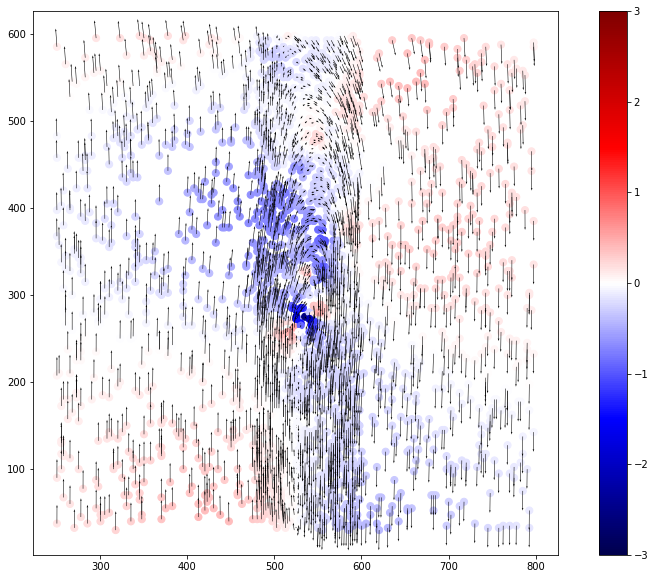

In [5]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
tmp = ax.scatter(data.easting, data.northing, s=50, c=data.up_velocity,
                 vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.colorbar(tmp, ax=ax)
ax.quiver(data.easting, data.northing, data.east_velocity, data.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")

In [6]:
(vd.maxabs(data.up_velocity)/vd.maxabs(data.east_velocity))**2, np.sqrt(ndata)

(0.1600331466674101, 50.0)

In [7]:
%%time
n = np.floor(np.sqrt(ndata))
force_coords = vd.grid_coordinates(vd.pad_region(region, 100), shape=(n, n))
#force_coords = None
weights = (np.full(ndata, 0.01), np.full(ndata, 0.01), np.full(ndata, 1.0))
spline = VectorSpline3D(poisson=0.1, depth=20, damping=1e-1, force_coords=force_coords)
spline.fit(coordinates, components, weights=weights)

CPU times: user 47.1 s, sys: 3.21 s, total: 50.3 s
Wall time: 9.14 s


In [8]:
%%time
print("Score on sampled data:", spline.score(coordinates, components))
print("Score on grid data:", spline.score(grid_coords, grid_components))

Score on sampled data: 0.9938947968079853
Score on grid data: 0.9947135463125824
CPU times: user 3.82 s, sys: 16.1 ms, total: 3.84 s
Wall time: 1.06 s


In [9]:
grid_spl = spline.grid(spacing=spacing, data_names=["east_velocity", 'north_velocity', "up_velocity"])

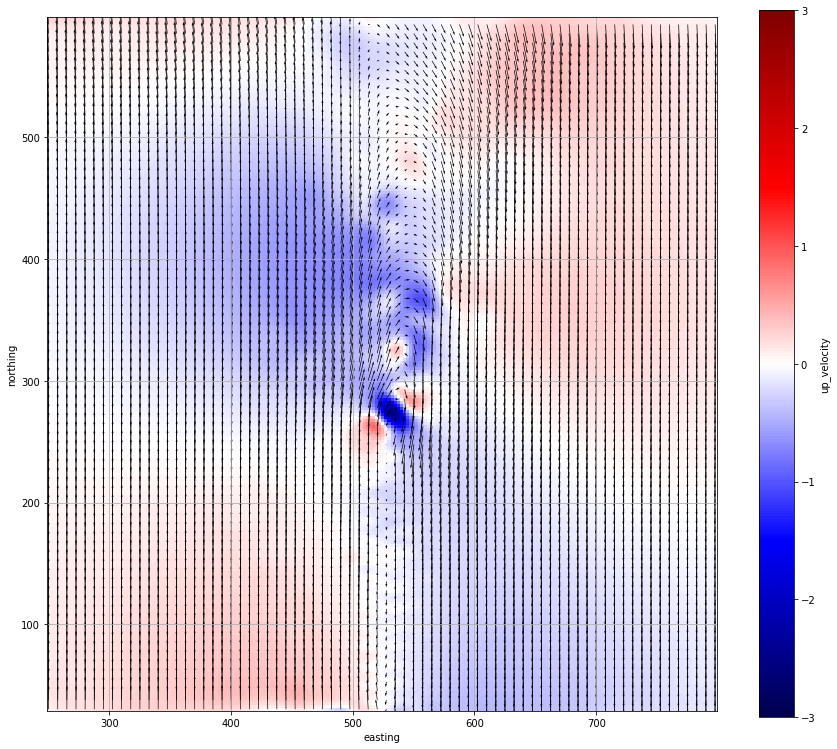

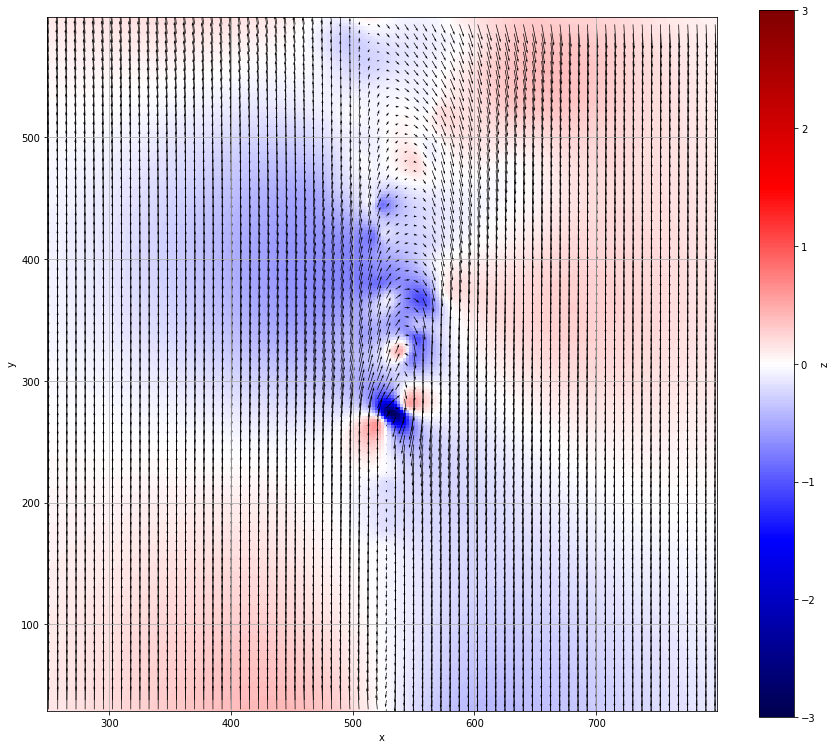

In [10]:
plt.figure(figsize=(15, 13))
ax = plt.subplot(111)
grid_spl.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = grid_spl.isel(easting=slice(None, None, every), 
                     northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()
plt.figure(figsize=(15, 13))
ax = plt.subplot(111)
grid.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = grid.isel(easting=slice(None, None, every), 
                 northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()

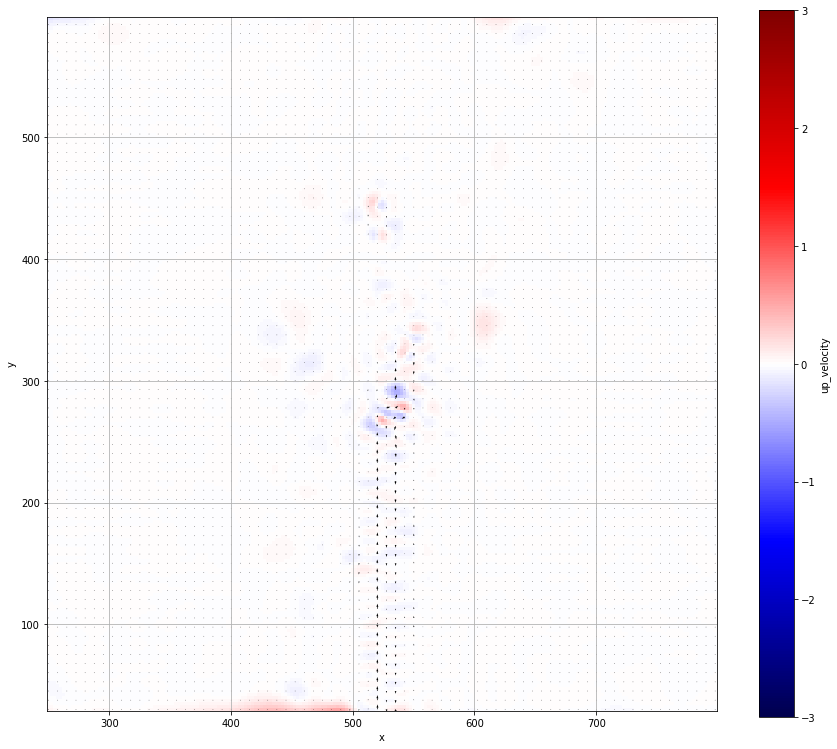

In [11]:
plt.figure(figsize=(15, 13))
ax = plt.subplot(111)
diff = grid - grid_spl
diff.up_velocity.plot.pcolormesh(vmin=-maxabs, vmax=maxabs, cmap="seismic")
down = diff.isel(easting=slice(None, None, every), 
                 northing=slice(None, None, every))
ax.quiver(down.easting, down.northing, down.east_velocity, down.north_velocity, scale=500, width=0.001)
ax.set_aspect("equal")
ax.grid()